In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('pseudonymized-data.csv')

In [3]:
df.head()

,Unnamed: 0,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1


In [4]:
df = df.rename(columns={df.columns[0]: 'id'})
df.head()

,id,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1


Clean data
- community -1
- all qns -1
- some qns -1


In [13]:
df = df[df["Community"] != "-1"]

,id,Community,V27,V28,V29,V30,V31,V32,V33
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
5,5,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
6,6,Comm.FOSSASIA,-1,5,5,3,2,1,3
...,...,...,...,...,...,...,...,...,...
375,382,Comm.OpenSUSE,3,5,5,5,2,1,4
376,383,Comm.ROS,5,5,5,5,2,2,3
377,384,Comm.Plone,4,5,5,4,4,4,3
378,385,Comm.Linux_Kernel,-1,-1,-1,-1,-1,-1,-1


In [14]:
df.iloc[:,1:].describe()

,V27,V28,V29,V30,V31,V32,V33
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,1.492754,1.533333,1.440580,1.623188,0.504348,0.344928,0.678261
std,2.648075,2.682776,2.605357,2.763453,1.689781,1.542003,1.864047
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,4.000000,4.000000,4.000000,5.000000,2.000000,1.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [15]:
communities = df.Community.unique()

print(len(communities))
print(communities)

13
['Comm.FOSSASIA' 'Comm.ROS' 'Comm.Coala' 'Comm.Mozilla'
 'Comm.Linux_Kernel' 'Comm.OpenGenus' 'Comm.ReactJS' 'Comm.Plone'
 'Comm.Odoo' 'Comm.NodeJS' 'Comm.Apache' 'Comm.jQuery' 'Comm.OpenSUSE']


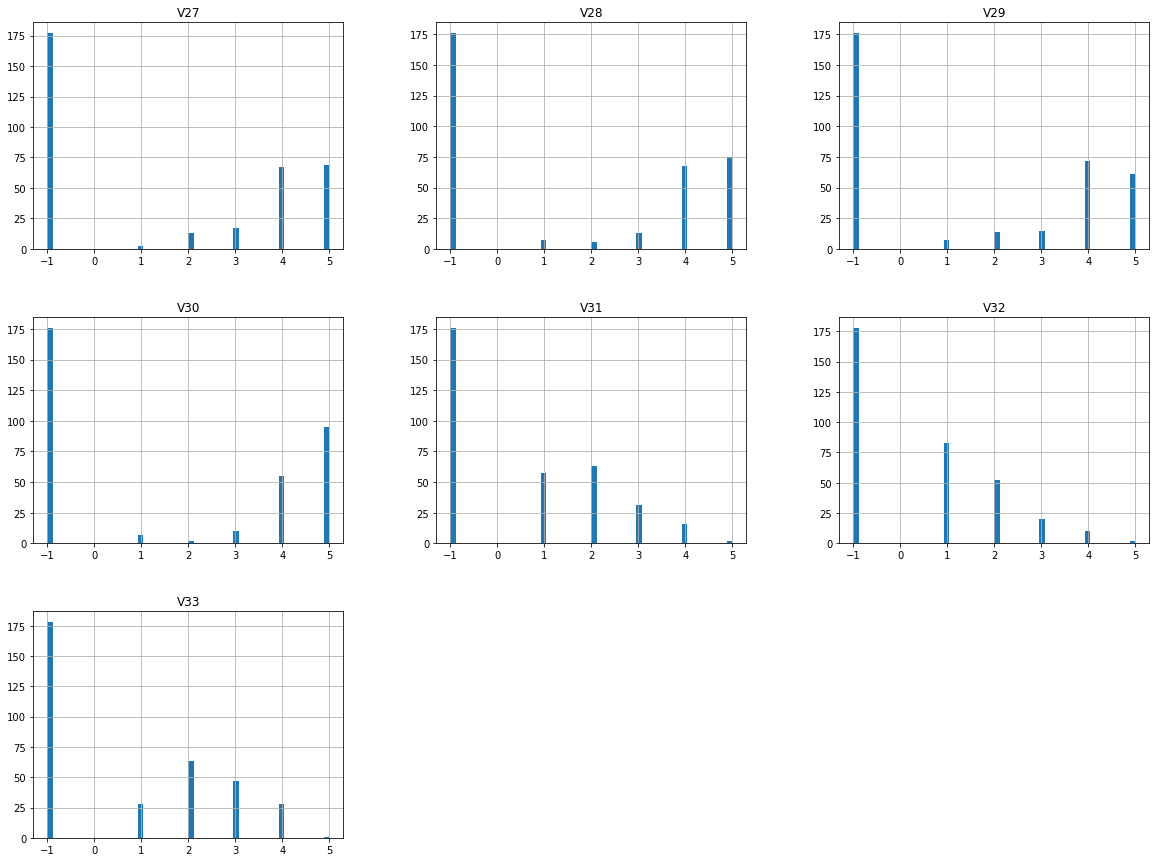

In [16]:
df.hist(column=df.columns[1:], bins=50, figsize=(20,15))
plt.show()

In [49]:
df[df.Community == 'Comm.FOSSASIA'].V27

0      4
1      5
2     -1
3     -1
4     -1
      ..
221   -1
223   -1
247    3
336   -1
366   -1
Name: V27, Length: 68, dtype: int64

In [103]:
# V27 = df[df.Community == 'Comm.FOSSASIA'].V27.to_numpy()
def removeNoAnswer(lst):
    return [int (i <= 3) for i in lst if i!=-1]
#    return lst[np.where(lst != -1)]

V27 = [removeNoAnswer(df[df.Community == community].V27.to_numpy()) for community in communities]
V28 = [removeNoAnswer(df[df.Community == community].V28.to_numpy())  for community in communities]
V29 = [removeNoAnswer(df[df.Community == community].V29.to_numpy())  for community in communities]
V30 = [removeNoAnswer(df[df.Community == community].V30.to_numpy())  for community in communities]
V31 = [removeNoAnswer(df[df.Community == community].V31.to_numpy())  for community in communities]
V32 = [removeNoAnswer(df[df.Community == community].V32.to_numpy())  for community in communities]
V33 = [removeNoAnswer(df[df.Community == community].V33.to_numpy())  for community in communities]
answers = [V27, V28, V29, V30, V31, V32, V33]

In [107]:
# %%
N = [len(V27), len(V28), len(V29), len(V30), len(V31), len(V32), len(V33)]
μ = [[np.mean(v) for v in V27], [np.mean(v) for v in V28], [np.mean(v) for v in V29],
     [np.mean(v) for v in V30], [np.mean(v) for v in V31], [np.mean(v) for v in V32], [np.mean(v) for v in V33]]
σ = [[np.std(v) for v in V27], [np.std(v) for v in V28], [np.std(v) for v in V29],
     [np.std(v) for v in V30], [np.std(v) for v in V31], [np.std(v) for v in V32], [np.std(v) for v in V33]]

# def standardize(data, m, sd):
#     return (data-m)/sd
# all_z = []
# for i in range(len(answers)):
#     lst=[]
#     for com in range(len(answers[i])):
#         z=standardize(answers[i][com], μ[i][com], σ[i][com])
#         lst.append(z)
#     all_z.append(lst)


In [109]:
np.array(answers).shape

<ipython-input-109-643bf9b24e26>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(answers).shape


(7, 13)

In [110]:
#begin H1
coalaIndex=np.where(communities=="Comm.Coala")[0][0]
linuxIndex=np.where(communities=="Comm.Linux_Kernel")[0][0]
z_coala=answers[coalaIndex][6]
z_linux=answers[linuxIndex][6]

print(z_coala,z_linux)

μ_coala=μ[coalaIndex][6]
μ_linux=μ[linuxIndex][6]
print("μ: ",μ_coala,μ_linux)


σ_coala=σ[coalaIndex][6]
σ_linux=σ[linuxIndex][6]
print("σ: ",σ_coala,σ_linux)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
μ:  0.1 1.0
σ:  0.30000000000000004 0.0


In [118]:
# put the model code 
with pm.Model() as model_h1:
    μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
    μ        = pm.Deterministic('μ', μ_noData*[μ_coala, μ_linux])
    σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
    σ        = pm.Deterministic('σ', σ_noData*[σ_coala, σ_linux])
    ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
    ν = pm.Deterministic('ν', ν_minus_one+1)
    
    # for plotting/comparison purposes
    log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
    eff_size = pm.Deterministic('eff_size',(μ-100)/σ)

    #likelihood
    obs_coala   = pm.StudentT('obs_coala',  nu=ν,mu=μ[0],sd=σ[0],observed=z_coala)
    obs_linux   = pm.StudentT('obs_linux',nu=ν,mu=μ[1],sd=σ[1],observed=z_linux)
    dif = pm.Deterministic('dif',abs(obs_coala-obs_linux))

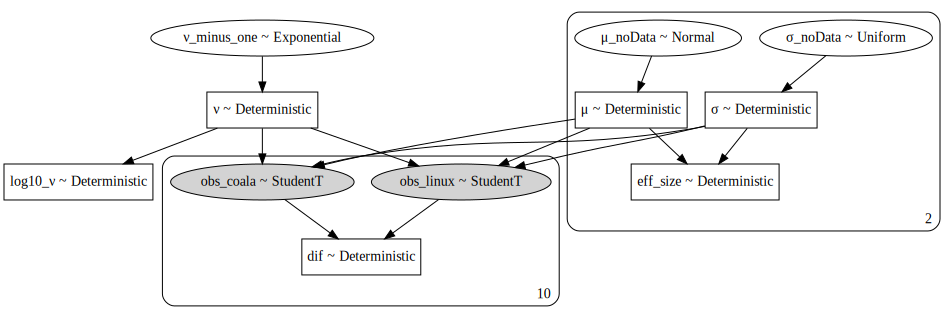

In [119]:
pm.model_to_graphviz(model_h1)

In [ ]:
# sampling: uncomment
trace_h1=pm.sample(10000,chains=2, model=model_h1)
# storing trace, since I am not waiting that long again
folderName ="h1.trace"
pm.save_trace(trace_h1, folderName, overwrite=True)
trace_h1 = pm.load_trace(folderName, model=model_h1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ν_minus_one, σ_noData, μ_noData]
Sampling 2 chains, 0 divergences:   0%|                                                   | 0/21000 [00:01<?, ?draws/s]


RuntimeError: Chain 0 failed.